### Problem Statement

- Predict the time evolution of a 1D damped harmonic oscillator ODE (e.g. the evolution of a spring-mass system with mass $m$, damping constant $\mu$, and spring constant $k$)
  
  $$
  m \frac{d^2x}{dt^2} + \mu \frac{dx}{dt} + kx = 0
  $$

  in the domain $t \in [0, 5]$ given some initially measured data points $(x(t_i), t_i)$.

* For reference, the analytical solution in the underdamped case ($\delta < w_0$) is
  $$
  x(t) = A \exp\left(-\delta t\right)\cos (\omega t + \phi),
  $$

  with constant $\delta = \frac{\mu}{2m}$, undamped angular frequency $w_0 = \sqrt{\frac{k}{m}}$, and damped angular frequency $\omega = \sqrt{\omega_0^2 -\delta^2}$. Furthermore, $A$ is the amplitude and $\phi$ is a phase shift the oscillation, both determined from the initial conditions (position and velocity). For our cases, we choose $A=1$ and $\phi = 0$.

### Approach

* Both a basic feed-forward NN and a PINN will be trained on the same training data. Then results and generalization capabilities are compared to the analytic solution.

* The physics function $f$ to be fulfilled by the PINN is
  $$
  f(t)=m\frac{d^2x}{dt^2} + \mu \frac{dx}{dt} + kx = 0.
  $$
  
  Later, the loss will then be calculated as
  $$
  L_{PDE} = \frac{1}{N} \sum_{i=1}^N f(t_i)^2.
  $$

### Training Setup

In [8]:
import torch
import torch.nn as nn
import numpy as np

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def oscillator(m, mu, k, A, phi, t):
    d = mu/(2*m)
    w0 = np.sqrt(k/m)
    assert d<w0
    w = np.sqrt(w0**2-d**2)
    return A*np.exp(-d*t)*np.cos(phi+w*t)

class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        # we have one input variable t and one predicted output variable x(t)
        self.layer1 = nn.Linear(1,10)
        self.layer2 = nn.Linear(10,10)
        self.layer3 = nn.Linear(10,10)
        self.layer4 = nn.Linear(10,1)
    
    def forward(self, t):
        l1_out = torch.sigmoid(self.layer1(t))
        l2_out = torch.sigmoid(self.layer2(l1_out))
        l3_out = torch.sigmoid(self.layer3(l2_out))
        l4_out = self.layer4(l3_out)
        return l4_out
    
class PINN(NN):
    def __init__(self, m, mu, k):
        super(PINN, self).__init__()
        self.m = m
        self.mu = mu
        self.k = k

    # this is the function f(x,t) on which the physics loss will be computed
    def ode_f(self, t): 
        x = self.forward(t)
        # use grad_outputs to set which elements to compute gradient on 
        # use create_graph to also create computational graph on gradient operation
        x_t = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]
        x_tt = torch.autograd.grad(x_t, t, grad_outputs=torch.ones_like(x_t), create_graph=True)[0]
        f = self.m*x_tt + self.mu*x_t + self.k*x
        return f

In [10]:
# Oscillator constants
m=1; mu=4; k=300; A=1; phi=0

# We want to compare a basic to physics informed NN
nn_basic = NN().to(device)
optimizer_basic = torch.optim.Adam(nn_basic.parameters())

pinn = PINN(m=m, mu=mu, k=k).to(device)
optimizer_pinn = torch.optim.Adam(pinn.parameters())

mse_loss = torch.nn.MSELoss()

In [11]:
# Create "experimental" points that fulfill initial condition 
t_init = np.linspace(0.0, 0.5, 500)
x_init = oscillator(m, mu, k, A, phi, t_init)

t_init_tensor = torch.from_numpy(t_init).reshape(-1,1).float().to(device)
x_init_tensor = torch.from_numpy(x_init).reshape(-1,1).float().to(device)

##### Train basic neural net

In [12]:
epoches = 10000
for epoch in range(epoches):
    optimizer_basic.zero_grad()

    # Boundary condition loss
    x_basic= nn_basic.forward(t_init_tensor)
    loss = mse_loss(x_basic, x_init_tensor)

    # Backpropagation
    loss.backward()
    optimizer_basic.step()

    if epoch%1000==0:
        with torch.autograd.no_grad():
            print(epoch, "Loss:", loss.data)


0 Loss: tensor(0.3039)
1000 Loss: tensor(0.2139)
2000 Loss: tensor(0.2137)
3000 Loss: tensor(0.1459)
4000 Loss: tensor(0.0031)
5000 Loss: tensor(0.0001)
6000 Loss: tensor(3.7919e-05)
7000 Loss: tensor(3.0959e-05)
8000 Loss: tensor(2.6483e-05)
9000 Loss: tensor(2.2619e-05)


##### Train PINN

In [13]:
epoches = 15000
for epoch in range(epoches):
    optimizer_pinn.zero_grad()

    # Boundary condition loss
    x_pinn = pinn.forward(t_init_tensor)
    data_loss = mse_loss(x_pinn, x_init_tensor)

    # Physics loss (due to PDE) 
    # Each epoch random points are generated and evaluated for how well the PINN is fulfilling the PDE at their location
    # t_random =  torch.from_numpy(np.random.uniform(low=0.0, high=1.0, size=(50,1))).float().requires_grad_(True)
    t_random =  torch.from_numpy(np.linspace(0.0, 1, 50)).reshape(-1,1).float().requires_grad_(True)
    net_f = pinn.ode_f(t_random)
    ode_loss = torch.mean(net_f**2)

    # Backpropagation
    loss = data_loss + 0.0001*ode_loss
    loss.backward()
    optimizer_pinn.step()

    if epoch%1000==0:
        with torch.autograd.no_grad():
            print(epoch, "Loss:", loss.data, data_loss, ode_loss)

0 Loss: tensor(0.3263) tensor(0.2358, grad_fn=<MseLossBackward0>) tensor(904.7239, grad_fn=<MeanBackward0>)
1000 Loss: tensor(0.2159) tensor(0.2157, grad_fn=<MseLossBackward0>) tensor(2.3559, grad_fn=<MeanBackward0>)
2000 Loss: tensor(0.2158) tensor(0.2154, grad_fn=<MseLossBackward0>) tensor(3.8038, grad_fn=<MeanBackward0>)
3000 Loss: tensor(0.2155) tensor(0.2150, grad_fn=<MseLossBackward0>) tensor(5.0009, grad_fn=<MeanBackward0>)
4000 Loss: tensor(0.2134) tensor(0.2119, grad_fn=<MseLossBackward0>) tensor(14.6666, grad_fn=<MeanBackward0>)
5000 Loss: tensor(0.0787) tensor(0.0459, grad_fn=<MseLossBackward0>) tensor(328.4410, grad_fn=<MeanBackward0>)
6000 Loss: tensor(0.0134) tensor(0.0023, grad_fn=<MseLossBackward0>) tensor(110.9672, grad_fn=<MeanBackward0>)
7000 Loss: tensor(0.0099) tensor(0.0009, grad_fn=<MseLossBackward0>) tensor(90.0147, grad_fn=<MeanBackward0>)
8000 Loss: tensor(0.0089) tensor(0.0007, grad_fn=<MseLossBackward0>) tensor(81.8404, grad_fn=<MeanBackward0>)
9000 Loss: te

### Plotting (with comparison to analytical solution)

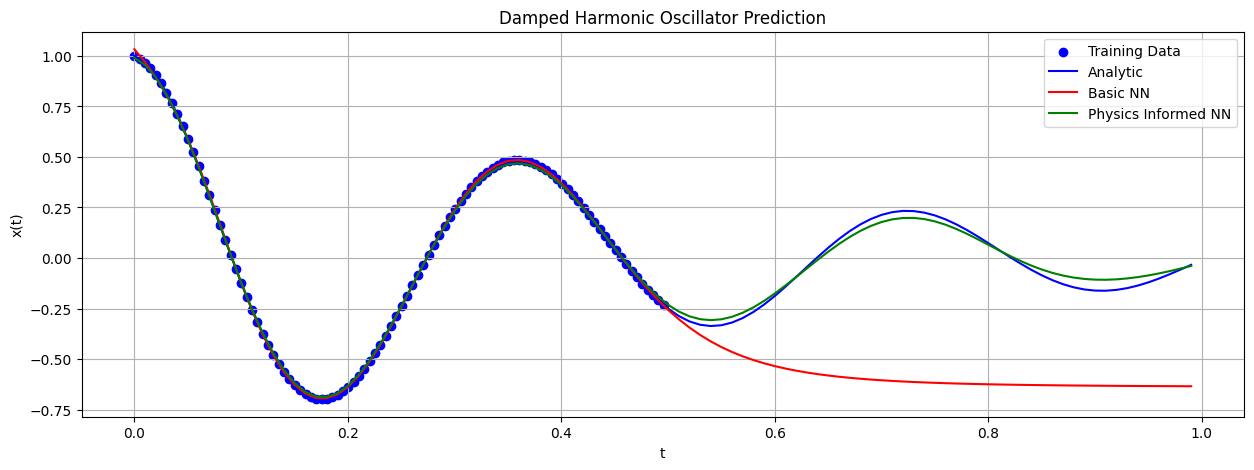

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))

# Create solution 
t = np.arange(0,1, 0.01)
t_tensor = torch.from_numpy(t).float().reshape(-1,1).to(device)

x_ana = oscillator(m, mu, k, A, phi, t)
with torch.no_grad():
    x_basic = nn_basic.forward(t_tensor).numpy()
with torch.no_grad():
    x_pinn = pinn.forward(t_tensor).numpy()

# Add the curves, labels, and a title to the plot
plt.scatter(t_init[0:-1:5], x_init[0:-1:5], color="blue", label="Training Data")
plt.plot(t, x_ana, label='Analytic', color='blue', linestyle='-')
plt.plot(t, x_basic, label='Basic NN', color='red', linestyle='-')
plt.plot(t, x_pinn, label='Physics Informed NN', color='green', linestyle='-')

plt.title('Damped Harmonic Oscillator Prediction')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend()
plt.grid(True)

### Conclusion

* The basic NN is good at modelling existing data but bad at extrapolation.
* The PINN is good at generalization as every extrapolation has to be physics informed, thus reducing the allowed parameter space.